# Projeto Aplicado 1

## Aula 02 - Aplicando Conhecimento

## Seção 0 - Configuração inicial

### Instalação dos pacotes necessários e atribuição de variáveis globais

In [ ]:
pip install jupyter polars matplotlib

In [21]:
# Ajuste o caminho conforme o local dos arquivos 'combined_data.txt' e 'movie_titles.csv'
caminho_arquivos = 'G:/Meu Drive/PARTICULAR/Cursos/Mackenzie/Etapa02/ProjetoAplicado1/dataset'

## Seção 1 - Funções

### Importação dos pacotes necessários

In [2]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

### Função que realiza a manipulação dos dados dentro dos arquivos, colocando-os em formato separado por vírgula

In [3]:
def carrega_arquivo_to_df(arquivo_origem):
    stt = []
    filme = ''
    with open(arquivo_origem) as arquivo:
        for line in arquivo:
            if line.find(":") > 0:
                filme = line.replace(':','').replace("\n", "")
            if line.find(":") < 0:
                row = filme + ',' + line.replace(':','').replace("\n", "")
                stt.append(row)
    
    df = pd.DataFrame([x.split(',') for x in stt])
    return df

### Função que carrega os dados de avaliação, montando o dataset

In [4]:
def carrega_assessment_df():
    df0 = pl.DataFrame(carrega_arquivo_to_df(caminho_arquivos + '/combined_data.txt'))

    frames = [df0]

    df_assessment = pl.concat(frames)
    df_assessment.columns = ['MovieID', 'CustomerID', 'Rating', 'Date']

    # Ajusta os tipos de dados para as colunas
    df_assessment = df_assessment.with_columns([
        pl.col("MovieID").cast(pl.Int32),
        pl.col("CustomerID").cast(pl.Int32),
        pl.col("Rating").cast(pl.Int32),
        pl.col("Date").cast(pl.Utf8)  # String type in Polars
    ])

    return df_assessment

### Função que carrega os títulos dos filmes

In [5]:
def carrega_csv_to_df():
    # Leitura do arquivo de títulos
    df = pl.read_csv(
        caminho_arquivos + '/movie_titles.csv',
        encoding="ISO-8859-1",
        separator=",",
        has_header=False,
        truncate_ragged_lines=True,
        infer_schema_length=10000,
        null_values=["NULL", ""],
    )

    # Renomeia as colunas
    expected_columns = ["MovieID", "Year", "Title"]

    # Garante que teremos apenas as 3 colunas
    df = df[:, :3]
    df.columns = expected_columns

    # Conversão de tipos de dados
    df = df.with_columns([
        pl.col("MovieID").cast(pl.Int32),
        pl.col("Year").cast(pl.Utf8),
        pl.col("Title").cast(pl.Utf8)
    ])

    return df

### Lê o arquivo com os dados de votação

In [8]:
df_assessment = carrega_assessment_df()

#### Lê o arquivo com os títulos dos filmes e atribui a um dataframe

In [9]:
df_movies = carrega_csv_to_df()

*Faz a junção dos datasets usando o campo MovieId como chave*

In [10]:
df_integrated = df_assessment.join(df_movies, on="MovieID", how="inner")

*Exibe as colunas e os tipos de dados*

In [11]:
df_integrated.schema

Schema([('MovieID', Int32),
        ('CustomerID', Int32),
        ('Rating', Int32),
        ('Date', String),
        ('Year', String),
        ('Title', String)])

In [12]:
df_integrated.head()

MovieID,CustomerID,Rating,Date,Year,Title
i32,i32,i32,str,str,str
1,1508350,4,"""2005-06-27""","""2003""","""Dinosaur Planet"""
1,2165002,4,"""2004-04-06""","""2003""","""Dinosaur Planet"""
1,1604707,4,"""2005-10-17""","""2003""","""Dinosaur Planet"""
1,2088415,4,"""2005-02-01""","""2003""","""Dinosaur Planet"""
1,818416,3,"""2005-07-27""","""2003""","""Dinosaur Planet"""


### Formato

In [13]:
df_integrated.shape

(134630, 6)

### Nulos

In [14]:
df_nulls = df_integrated.null_count()
print(df_nulls)

shape: (1, 6)
┌─────────┬────────────┬────────┬──────┬──────┬───────┐
│ MovieID ┆ CustomerID ┆ Rating ┆ Date ┆ Year ┆ Title │
│ ---     ┆ ---        ┆ ---    ┆ ---  ┆ ---  ┆ ---   │
│ u32     ┆ u32        ┆ u32    ┆ u32  ┆ u32  ┆ u32   │
╞═════════╪════════════╪════════╪══════╪══════╪═══════╡
│ 0       ┆ 0          ┆ 0      ┆ 0    ┆ 35   ┆ 0     │
└─────────┴────────────┴────────┴──────┴──────┴───────┘


### Descrição

In [15]:
df_integrated.describe()

statistic,MovieID,CustomerID,Rating,Date,Year,Title
str,f64,f64,f64,str,str,str
"""count""",134630.0,134630.0,134630.0,"""134630""","""134595""","""134630"""
"""null_count""",0.0,0.0,0.0,"""0""","""35""","""0"""
"""mean""",2241.776974,1.3296e6,3.220181,null,null,null
"""std""",1297.966552,765081.369003,1.225771,null,null,null
"""min""",1.0,6.0,1.0,"""1999-12-30""","""1915""","""'N Sync: 'N the Mix"""
"""25%""",1114.0,664090.0,2.0,null,null,null
"""50%""",2236.0,1.328713e6,3.0,null,null,null
"""75%""",3365.0,1.996999e6,4.0,null,null,null
"""max""",4499.0,2.649388e6,5.0,"""2005-12-31""","""2005""","""s-Cry-ed"""


### Valores únicos

In [16]:
df_integrated.n_unique()

134630

### Distribuição das avaliações

In [17]:
df_integrated.select(pl.col("Rating").value_counts()).sort("Rating")

Rating
struct[2]
"{1,15413}"
"{2,20270}"
"{3,41282}"
"{4,34591}"
"{5,23074}"


### Média geral das avaliações

In [23]:
df_integrated.select(pl.col('Rating').mean()).to_series().item()

3.2201812374656464

## Seção 2 - Gráficos

### 1. Histograma de Filmes Por Média de Avaliações

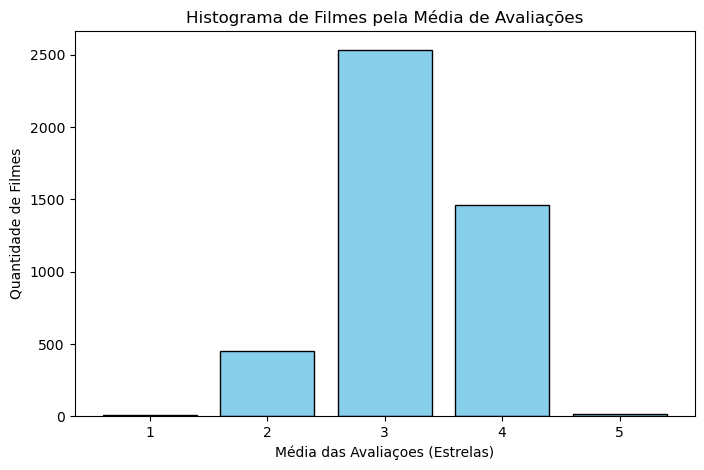

In [18]:
# Cálculo da média de avaliação por filme, agrupado pelo campo Title (Título do filme)
df_avg_rating = (df_integrated.group_by("Title").agg(pl.col("Rating").mean().alias("avg_rating")))

# Arredonda a média da avaliação para o próximo inteiro (de 1 a 5)
df_avg_rating = df_avg_rating.with_columns(pl.col("avg_rating").round(0).cast(pl.Int32).alias("rounded_avg_rating"))

# Agrupa as médias arredondadas e conta a quantidade de filmes em cada agrupamento
rating_hist = (df_avg_rating.group_by("rounded_avg_rating").agg(pl.len().alias("count")).sort("rounded_avg_rating"))

# Converte para um Dataframe do Pandas, para ficar mais simples a plitagem
rating_hist_pd = rating_hist.to_pandas()

# Cria o histograma como Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(rating_hist_pd["rounded_avg_rating"], rating_hist_pd["count"],
        color='skyblue', edgecolor='black')
plt.xlabel("Média das Avaliaçoes (Estrelas)")
plt.ylabel("Quantidade de Filmes")
plt.title("Histograma de Filmes pela Média de Avaliações")
plt.xticks(range(1, 6))  # Ensure x-axis shows ratings from 1 to 5
plt.show()
print('\n')

### 2. Popularidade vs Média de Avaliação dos Filmes

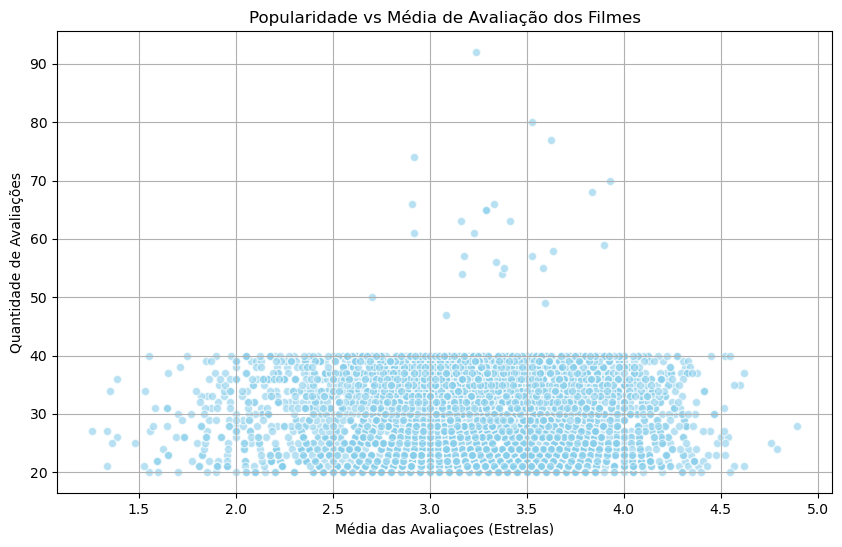

In [19]:
# Calcula a avaliação média e número de avaliações por filme
df_movies_stats = (df_integrated.group_by("Title").agg([pl.col("Rating").mean().alias("avg_rating"), pl.len().alias("num_ratings")]))

# Converte para um Dataframe do Pandas, para ficar mais simples a plitagem
df_movies_stats_pd = df_movies_stats.to_pandas()

# Cria o gráfico de Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_movies_stats_pd["avg_rating"], df_movies_stats_pd["num_ratings"], alpha=0.6, edgecolors="w", color="skyblue")
plt.xlabel("Média das Avaliaçoes (Estrelas)")
plt.ylabel("Quantidade de Avaliações")
plt.title("Popularidade vs Média de Avaliação dos Filmes")
plt.grid(True)
plt.show()

### 3. Total e Média das Avaliaçoes por Ano com Desvio Padrão

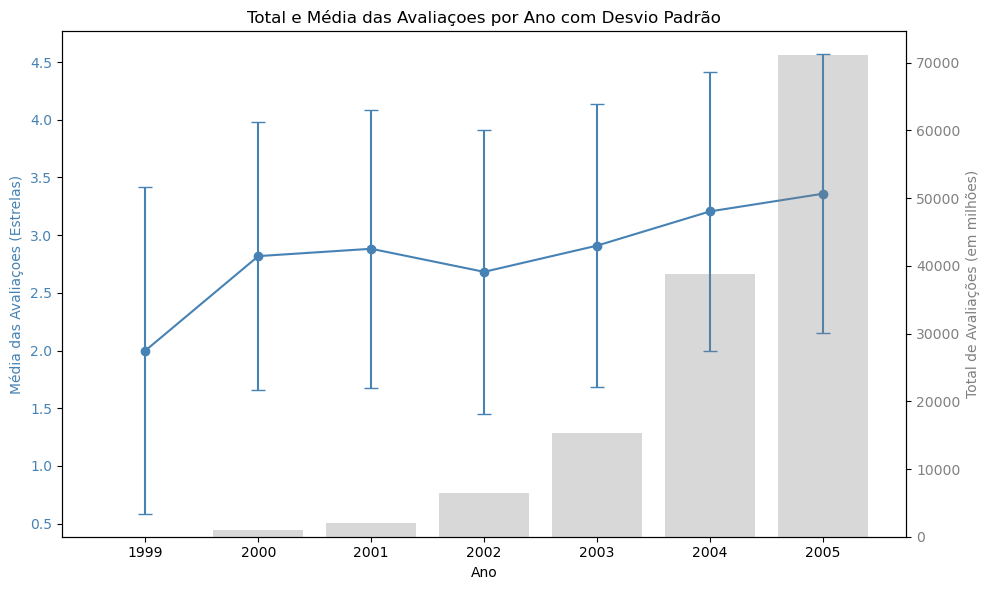

In [20]:
# Extrai o ano e realiza a agregação (avaliação média, desvio padrão e total de avaliações)
df_year = (df_integrated.with_columns(pl.col("Date").str.slice(0, 4).alias("Year"))
    .group_by("Year")
    .agg([
        pl.col("Rating").mean().alias("avg_rating"),
        pl.col("Rating").std().alias("std_rating"),
        pl.len().alias("total_ratings")
    ])
    .sort("Year")
)

# Converte para um Dataframe do Pandas, para ficar mais simples a plitagem
df_year_pd = df_year.to_pandas()

# Converte o ano (Year) para inteiro para melhor formatação do eixo X
df_year_pd['Year'] = df_year_pd['Year'].astype(int)

# Cria o gráfico usando dois eixos Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Cria o eixo y primário com a média de avaliações
ax1.errorbar(
    df_year_pd["Year"],
    df_year_pd["avg_rating"],
    yerr=df_year_pd["std_rating"],
    fmt='-o',
    capsize=5,
    color='steelblue',
    label='Average Rating'
)
ax1.set_xlabel("Ano")
ax1.set_ylabel("Média das Avaliaçoes (Estrelas)", color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Cria o eixo y secundário com o total de avaliações
ax2 = ax1.twinx()
ax2.bar(
    df_year_pd["Year"],
    df_year_pd["total_ratings"],
    alpha=0.3,
    color='gray',
    label='Total de avaliações'
)
ax2.set_ylabel("Total de Avaliações (em milhões)", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title("Total e Média das Avaliaçoes por Ano com Desvio Padrão")
fig.tight_layout()
plt.show()